# **IMPORTING DEPENDANCIES**

In [1]:
import os
import glob
import shutil
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
from tqdm.notebook import tqdm
import pydicom  as dicom
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, GlobalAveragePooling3D, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from keras.callbacks import  ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from keras.metrics import AUC
from sklearn.model_selection import train_test_split

# **DATASET VISUALIZATION** 

In [2]:
dataset_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'

mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
mri_types_id = 0

image_size = 120
num_images_per_type = 6
total_num_images = num_images_per_type * len(mri_types)
BATCH_SIZE = 4

train_df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
sample_submission = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')

errors_to_excluded = [109, 123, 709]
train_df = train_df[~train_df['BraTS21ID'].isin(errors_to_excluded)]

train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID]

print(len(train_df))
train_df

582


,BraTS21ID,MGMT_value,BraTS21ID5
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006
...,...,...,...
580,1005,1,01005
581,1007,1,01007
582,1008,1,01008
583,1009,0,01009


### **Dataset Distribution**

Text(0.5, 1.0, 'MGMT value distribution in the dataset\n')

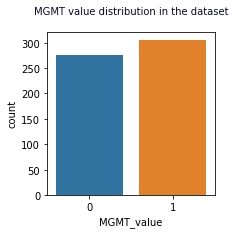

In [3]:
plt.figure(figsize = (3, 3))
sns.countplot(data = train_df, x = 'MGMT_value')
plt.title("MGMT value distribution in the dataset\n",fontsize=10, color="#0b0a2d")

# **SPLITTING THE DATA**

### **Splitting the data into Training and Testing data** 

In [4]:
df_training, df_test = train_test_split(
    train_df,
    train_size = 0.8,
    test_size = 0.2,
    random_state = 12,
    stratify = train_df['MGMT_value']
)

### **Splitting the Training data into Training and Validation data** 

In [5]:
df_train, df_validation = train_test_split(
    df_training,
    train_size = 0.8,
    test_size = 0.2,
    random_state = 12,
    stratify = df_training['MGMT_value']
)

### ***Training Data*** 

Number of samples in the training set is: 372


,BraTS21ID,MGMT_value,BraTS21ID5
363,537,1,00537
554,808,1,00808
497,728,0,00728
298,432,0,00432
321,472,1,00472
141,212,1,00212
486,707,1,00707
410,594,1,00594
565,828,1,00828
570,838,1,00838


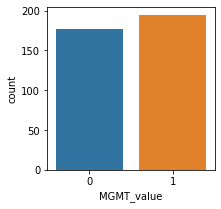

In [6]:
plt.figure(figsize = (3, 3))
sns.countplot(data = df_train, x = 'MGMT_value')

print('Number of samples in the training set is:', len(df_train))
df_train.head(10)

### ***Validation Data*** 

Number of samples in the validation set is: 93


,BraTS21ID,MGMT_value,BraTS21ID5
525,772,1,00772
244,352,1,00352
335,498,0,00498
397,578,0,00578
83,128,1,00128
516,756,0,00756
325,480,1,00480
116,172,0,00172
28,45,0,00045
370,545,0,00545


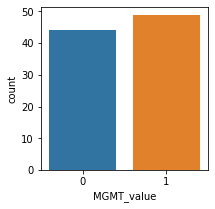

In [7]:
plt.figure(figsize = (3, 3))
sns.countplot(data = df_validation, x = 'MGMT_value')

print('Number of samples in the validation set is:', len(df_validation))
df_validation.head(10)

### ***Testing Data*** 

Number of samples in the testing set is: 117


,BraTS21ID,MGMT_value,BraTS21ID5
96,146,1,00146
380,557,1,00557
302,441,0,00441
522,765,1,00765
145,218,0,00218
453,655,1,00655
212,310,0,00310
505,736,1,00736
252,369,1,00369
164,243,0,00243


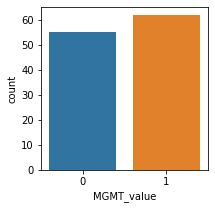

In [8]:
plt.figure(figsize = (3, 3))
sns.countplot(data = df_test, x = 'MGMT_value')

print('Number of samples in the testing set is:', len(df_test))
df_test.head(10)

# **DATA CLEANING**

% of colored pixels : 7.05


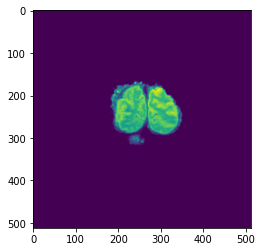

In [9]:
sample_img_path = ''.join([dataset_directory, '/train/00005/FLAIR/Image-80.dcm'])
sample_img = dicom.dcmread(sample_img_path)
sample_img = sample_img.pixel_array
plt.imshow(sample_img)
print("% of colored pixels : {:.2f}".format(np.sum(np.where(sample_img!=0,1,0)/(sample_img.shape[0]*sample_img.shape[1]))*100))

<function matplotlib.pyplot.show(close=None, block=None)>

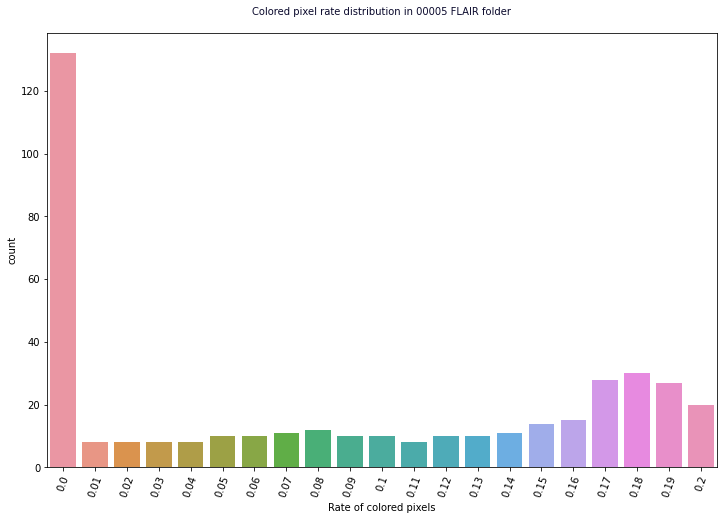

In [10]:
img_colored = []
g_path = ''.join([dataset_directory, '/train/00005/FLAIR/'])
for imgs in os.listdir(g_path):
    img_path = ''.join([g_path, imgs])
    temp_img = dicom.dcmread(img_path)
    temp_img = temp_img.pixel_array
    colored_zone = round(np.sum(np.where(temp_img!=0,1,0)/(temp_img.shape[0]*temp_img.shape[1])),2)
    img_colored.append(colored_zone)

fig = plt.figure(figsize = (12, 8))
sns.countplot(x = img_colored)
plt.xlabel('Rate of colored pixels')
plt.xticks(rotation = 70)
plt.title('Colored pixel rate distribution in 00005 FLAIR folder\n', fontsize = 10, color = '#0b0a2d')
plt.show

# **PREPROCESSING**

### **Crop & Resize the images**

In [11]:
def crop_resize_img(img, scale = 1.0, dim = (244, 244)):
    # Crop image
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    
    # Resize image
    img_cropped = cv2.resize(img_cropped, dim, interpolation = cv2.INTER_AREA)
    return img_cropped

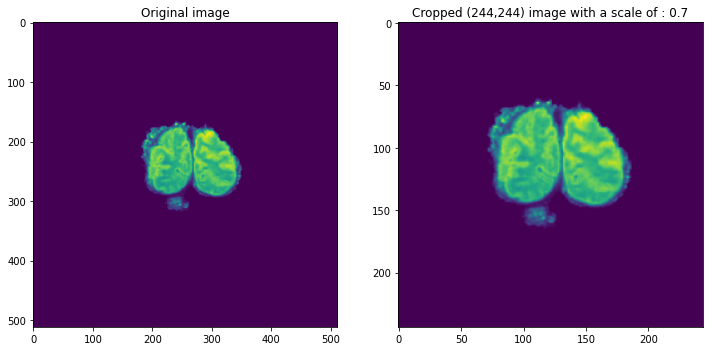

In [12]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(1,2,1)
ax.imshow(sample_img)
ax.set_title("Original image")
ax1 = plt.subplot(1,2,2)
img_cropped = crop_resize_img(sample_img, 0.7, (244,244))
ax1.imshow(img_cropped)
ax1.set_title("Cropped (244,244) image with a scale of : 0.7")
plt.show()

### **Global Preprocessing Function**

In [13]:
def mri_preprocessor(img, scale = 0.8, dim = (240, 240)):
    x = crop_resize_img(img, scale, dim)
    return x

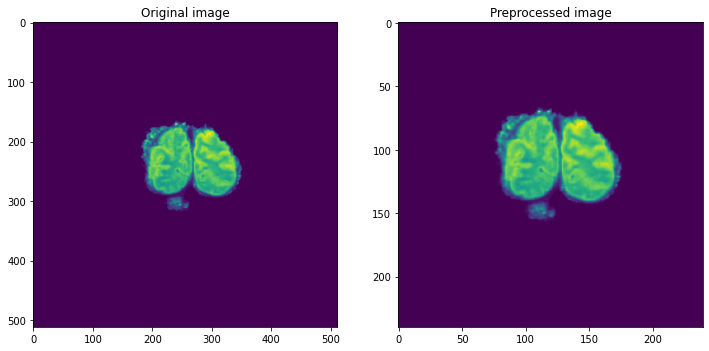

In [14]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
ax.imshow(sample_img)
ax.set_title("Original image")
ax1 = plt.subplot(1,2,2)
img_pre = mri_preprocessor(sample_img, scale=.8, dim=(240,240))
ax1.imshow(img_pre)
ax1.set_title("Preprocessed image")
plt.show()

# **FUNCTIONS TO LOAD IMAGES**

In [15]:
def load_dicom_image(path, img_size = image_size, preproc = True):
    data = dicom.read_file(path)
    data = data.pixel_array
    
    if(preproc == True):
        data = mri_preprocessor(data, scale = 0.8, dim = (img_size, img_size))
    else:
        data = cv2.resize(data, (img_size, img_size))
    return data

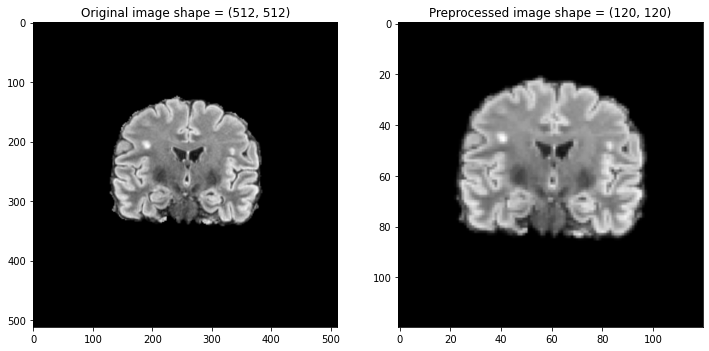

In [16]:
sample_img = dicom.read_file(dataset_directory+"/train/00046/FLAIR/Image-90.dcm").pixel_array
preproc_img = load_dicom_image(dataset_directory+"/train/00046/FLAIR/Image-90.dcm",preproc=True)

fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(1,2,1)
ax1.imshow(sample_img, cmap="gray")
ax1.set_title(f"Original image shape = {sample_img.shape}")
ax2 = plt.subplot(1,2,2)
ax2.imshow(preproc_img, cmap="gray")
ax2.set_title(f"Preprocessed image shape = {preproc_img.shape}")
plt.show()

In [17]:
def load_dicom_images_3d(scan_id, mri_type='FLAIR', num_imgs = total_num_images, img_size = image_size, split = 'train'):
    
        files = sorted(glob.glob(f'{dataset_directory}/{split}/{scan_id}/{mri_type}/*.dcm'), 
                   key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

        middle = len(files)//2
        num_imgs2 = num_imgs//2
        p1 = max(0, middle - num_imgs2)
        p2 = min(len(files), middle + num_imgs2)
        img3d = np.stack([load_dicom_image(f) for f in files[p1:p2]], axis=-1) 
        if img3d.shape[-1] < num_imgs:
            n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
            img3d = np.concatenate((img3d,  n_zero), axis = -1)

        if np.min(img3d) < np.max(img3d):
            img3d = img3d - np.min(img3d)
            img3d = img3d / np.max(img3d)
            
        return img3d

(120, 120, 24)
Dimension of the MRI scan is: (120, 120)


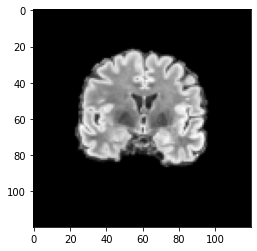

In [18]:
a = load_dicom_images_3d("00046")
print(np.array(a).shape)
image = a[:, :, 12]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image), cmap="gray")

# **KERAS CUSTOM DATA GENERATOR**

In [19]:
from tensorflow.keras.utils import Sequence

class Dataset(Sequence): 
    def __init__(self, df, is_train = True, batch_size = BATCH_SIZE, shuffle = False):
        self.idx = df["BraTS21ID"].values
        self.paths = df["BraTS21ID5"].values
        self.y =  df["MGMT_value"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
   
    def __getitem__(self,ids):
        id_path= self.paths[ids]
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
        
        if self.is_train:
            self.full_X_mri = []
            for mri_type in mri_types:
                list_x =  [load_dicom_images_3d(x, split="train", mri_type = mri_type) for x in batch_paths]
                batch_X = np.stack(list_x, axis=0)
                self.full_X_mri.append(np.array(batch_X))
            return self.full_X_mri,np.array(batch_y)
        else:
            self.full_X_mri = []
            for mri_type in mri_types:
                list_x =  load_dicom_images_3d(id_path, split="test", mri_type = mri_type)
                batch_X = np.stack(np.expand_dims(list_x, axis=0))
                self.full_X_mri.append(np.array(batch_X))
            return self.full_X_mri
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            tf.random_shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))

In [20]:
train_dataset = Dataset(df_train,batch_size=BATCH_SIZE)
validation_dataset = Dataset(df_validation,batch_size=BATCH_SIZE)

Number of MRI types: 4
Dimension of the MRI FLAIR scan is: (4, 120, 120, 24)
label = [1 1 0 0]




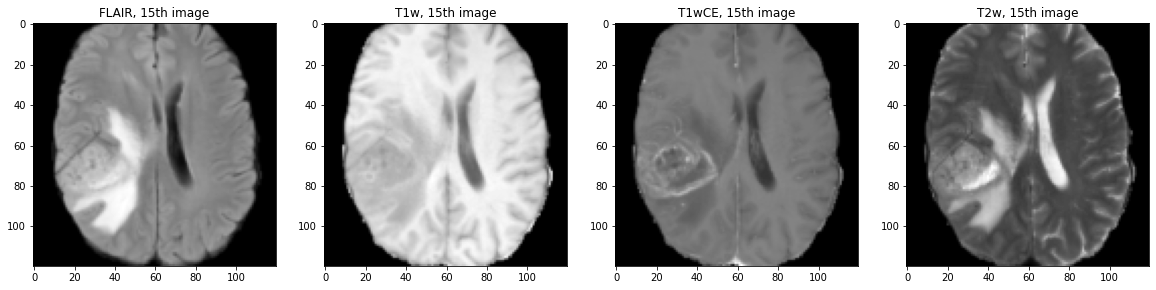

In [21]:
fig = plt.figure(figsize=(20,8))

for i in range(1):
    images, label = train_dataset[i]
    print("Number of MRI types:", len(images))
    print("Dimension of the MRI FLAIR scan is:", images[1].shape)
    print("label =",label)
    print("\n")
    
    ax1 = plt.subplot(1,4,1)
    ax1.imshow(images[0][1][:,:,15], cmap="gray")
    ax1.set_title("FLAIR, 15th image")
    ax2 = plt.subplot(1,4,2)
    ax2.imshow(images[1][1][:,:,15], cmap="gray")
    ax2.set_title("T1w, 15th image")
    ax3 = plt.subplot(1,4,3)
    ax3.imshow(images[2][1][:,:,15], cmap="gray")
    ax3.set_title("T1wCE, 15th image")
    ax4 = plt.subplot(1,4,4)
    ax4.imshow(images[3][1][:,:,15], cmap="gray")
    ax4.set_title("T2w, 15th image")

# **CNN MULTI-INPUTS MODEL**

In [22]:
def get_model(inputs):
    """Build a 3D convolutional neural network model."""
     
    x = Conv3D(filters=16, kernel_size=3, activation="relu", padding="same")(inputs)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    return x

In [23]:
# Create the four modal input
FLAIR_input = Input(shape=(image_size, image_size, total_num_images, 1))
FLAIR_model = get_model(FLAIR_input)

T1w_input = Input(shape=(image_size, image_size, total_num_images, 1))
T1w_model = get_model(T1w_input)

T1wCE_input = Input(shape=(image_size, image_size, total_num_images, 1))
T1wCE_model = get_model(T1wCE_input)

T2w_input = Input(shape=(image_size, image_size, total_num_images, 1))
T2w_model = get_model(T2w_input)

# Concatenate models and add final block
cnn = concatenate([FLAIR_model, T1w_model, T1wCE_model, T2w_model])

cnn = GlobalAveragePooling3D()(cnn)
cnn = Dense(units=256, activation="relu")(cnn)
cnn = Dropout(0.3)(cnn)

# Output layer
output_layer = Dense(units = 1, activation = 'sigmoid')(cnn)

# Final model
cnn_model = Model(inputs=[FLAIR_input, 
                          T1w_input, 
                          T1wCE_input, 
                          T2w_input], 
                  outputs=[output_layer],
                  name="multi3dcnn")

# Compile final model
cnn_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["accuracy"])

# Define callbacks.
model_save = ModelCheckpoint(f'Glioblastoma_Gene_Type_Classification_Using_3d_CNN.h5', 
                             save_best_only = True, 
                             monitor = 'val_loss', 
                             mode = 'min', 
                             verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', 
                           patience = 15, 
                           mode = 'min', 
                           verbose = 1, 
                           restore_best_weights = True)

2021-12-28 21:26:29.396653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 21:26:29.489230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 21:26:29.490110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 21:26:29.491272: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

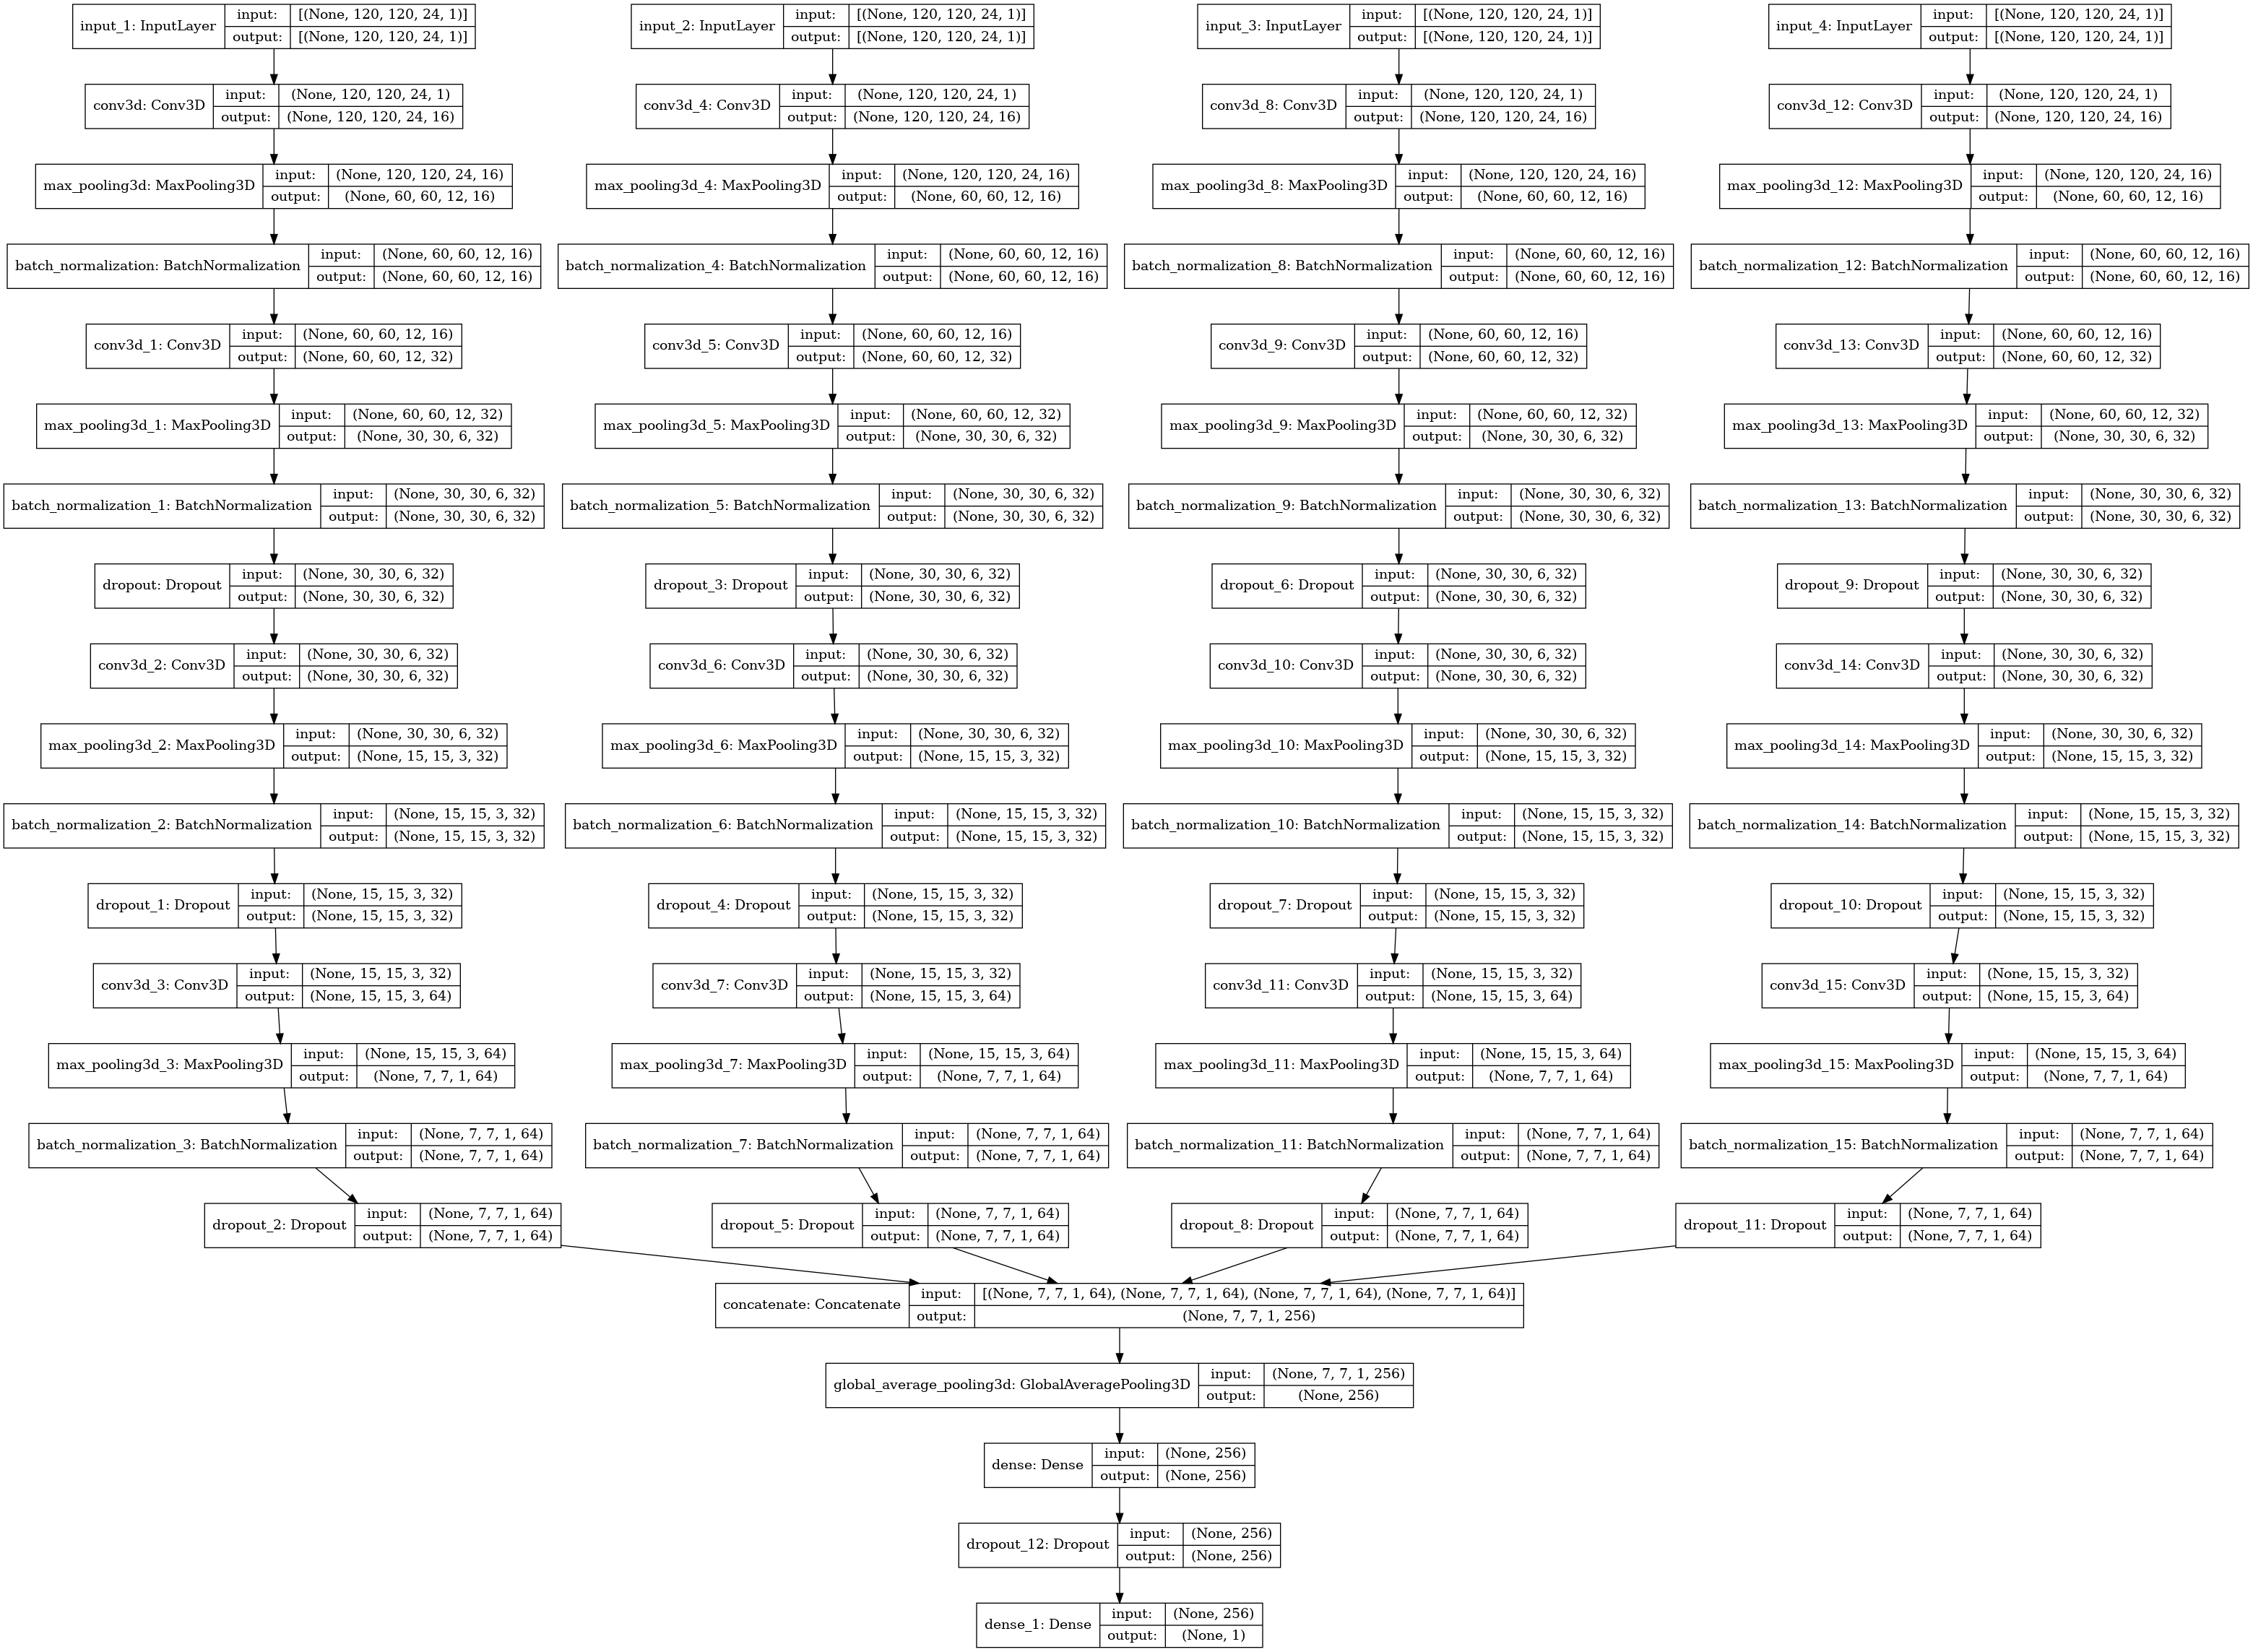

In [24]:
plot_model(cnn_model, show_shapes = True, show_layer_names = True)

In [25]:
epochs = 50
cnn_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = epochs,
    shuffle = False,
    callbacks = [model_save, early_stop]
)

2021-12-28 21:26:34.675594: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-12-28 21:26:38.382655: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


93/93 [==============================] - 478s 5s/step - loss: 0.7616 - accuracy: 0.5349 - val_loss: 0.8602 - val_accuracy: 0.4731

Epoch 00001: val_loss improved from inf to 0.86025, saving model to Glioblastoma_Gene_Type_Classification_Using_3d_CNN.h5
Epoch 2/50
93/93 [==============================] - 366s 4s/step - loss: 0.7257 - accuracy: 0.5403 - val_loss: 0.9723 - val_accuracy: 0.4731

Epoch 00002: val_loss did not improve from 0.86025
Epoch 3/50
93/93 [==============================] - 368s 4s/step - loss: 0.6858 - accuracy: 0.5806 - val_loss: 1.0295 - val_accuracy: 0.4731

Epoch 00003: val_loss did not improve from 0.86025
Epoch 4/50
93/93 [==============================] - 373s 4s/step - loss: 0.6778 - accuracy: 0.5887 - val_loss: 0.7820 - val_accuracy: 0.4731

Epoch 00004: val_loss improved from 0.86025 to 0.78197, saving model to Glioblastoma_Gene_Type_Classification_Using_3d_CNN.h5
Epoch 5/50
93/93 [==============================] - 368s 4s/step - loss: 0.6861 - accuracy: 0

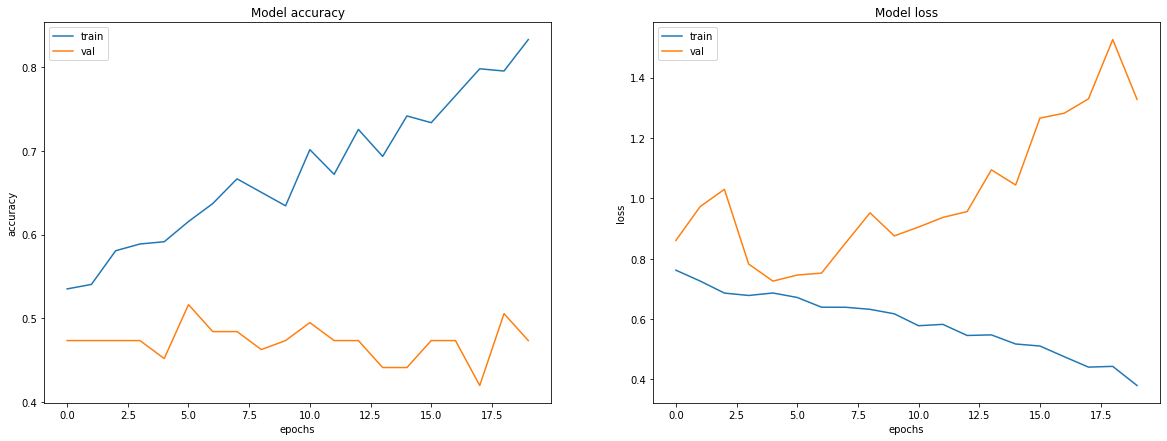

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax = ax.ravel()

for i, metric in enumerate(["accuracy","loss"]):
    ax[i].plot(cnn_model.history.history[metric])
    ax[i].plot(cnn_model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# **TESTING THE FINAL MODEL**

In [27]:
test_dataset = Dataset(df_test, batch_size = 1)

print(len(test_dataset))

117


In [28]:
predictions = cnn_model.predict(test_dataset)
predictions = predictions.reshape(-1)

In [29]:
print(predictions.shape)
print(predictions)

(117,)
[0.6331417  0.64833736 0.46991822 0.56627256 0.6368104  0.53090763
 0.35315797 0.47080556 0.5726064  0.73670435 0.40201968 0.539013
 0.24451028 0.6052833  0.44092155 0.31286773 0.7271535  0.27824748
 0.64659894 0.38646653 0.47458377 0.3866184  0.5494627  0.45204806
 0.4609635  0.41114548 0.26468143 0.24773678 0.56246984 0.32742205
 0.406651   0.4239048  0.39817214 0.2227361  0.46211842 0.25446755
 0.27225825 0.59628206 0.4584827  0.6647954  0.38752714 0.4678171
 0.53972423 0.53768784 0.4029921  0.3385711  0.56890184 0.5945265
 0.30202344 0.25910476 0.50878763 0.49345148 0.19981128 0.4003043
 0.38546854 0.24512869 0.6032837  0.65824187 0.5220156  0.36392123
 0.34917298 0.26224232 0.4840394  0.27889124 0.3779058  0.5128013
 0.511206   0.3021499  0.44245178 0.267118   0.4369318  0.5295993
 0.5019118  0.54100573 0.62217236 0.5770538  0.33941743 0.3174339
 0.2792383  0.39134488 0.37924492 0.49785343 0.7247599  0.50289845
 0.6090417  0.4568887  0.26257443 0.5286167  0.36321607 0.76798

In [30]:
results = pd.DataFrame({'BraTS21ID':df_test['BraTS21ID'],'MGMT_value':predictions})
results.head(10)

,BraTS21ID,MGMT_value
96,146,0.633142
380,557,0.648337
302,441,0.469918
522,765,0.566273
145,218,0.636810
453,655,0.530908
212,310,0.353158
505,736,0.470806
252,369,0.572606
164,243,0.736704


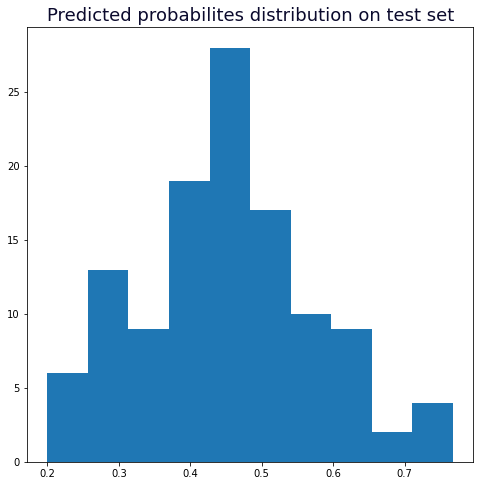

In [31]:
plt.figure(figsize=(8, 8))
plt.hist(results["MGMT_value"])
plt.title("Predicted probabilites distribution on test set", fontsize=18, color="#0b0a2d")
plt.show()

In [32]:
# Load best weights.
cnn_model.load_weights('Glioblastoma_Gene_Type_Classification_Using_3d_CNN.h5')
prediction = cnn_model.predict(test_dataset)[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["Present", "Not Present"]
for score, name in zip(scores, class_names):
    print("This model is %.2f percent confident that MGMT is %s" % ((100 * score), name))

This model is 36.69 percent confident that MGMT is Present
This model is 63.31 percent confident that MGMT is Not Present
